In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
%matplotlib inline
warnings.filterwarnings("ignore", category=UserWarning)
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import matthews_corrcoef

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import time
from sklearn import metrics
from sklearn.metrics import accuracy_score

from wordcloud import WordCloud

### Getting Data
##### Getting Data From Csv's

In [2]:
cards_data = pd.read_csv('datasets/cards_data.csv')
users_data = pd.read_csv('datasets/users_data.csv')
users_data.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,$37891,$77254,$191349,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,$22681,$33483,$196,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,$163145,$249925,$202328,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,$53797,$109687,$183855,675,1


##### Getting Data From Json's

In [3]:
with open('datasets/mcc_codes.json','r') as mcc_codes:
    data = json.load(mcc_codes)
with open('datasets/train_fraud_labels.json','r') as fraud_label:
    target = json.load(fraud_label)

In [4]:
mcc_codes = pd.DataFrame(list(data.items()), columns=['mcc', 'Description'])
fraud_label_target = pd.DataFrame(list(target.get('target').items()), columns=['transaction_id', 'fraud'])

##### Getting Data from Database

In [5]:
from db_connection import connect_to_db
connection = connect_to_db()
query = "SELECT * FROM transaction"
transaction_data = pd.read_sql(query, connection)

In [6]:
cards_data['credit_limit'] = cards_data['credit_limit'].str.replace('$', '', regex=False).str.replace(',', '').astype(float)
users_data['per_capita_income'] = users_data['per_capita_income'].str.replace('$', '', regex=False).str.replace(',', '').astype(float)
users_data['yearly_income'] = users_data['yearly_income'].str.replace('$', '', regex=False).str.replace(',', '').astype(float)
users_data['total_debt'] = users_data['total_debt'].str.replace('$', '', regex=False).str.replace(',', '').astype(float)
mcc_codes.mcc  = mcc_codes.mcc.astype(int)
fraud_label_target.transaction_id  = fraud_label_target.transaction_id.astype(int)
transaction_data.date = pd.to_datetime(transaction_data.date)

### Merging DataFrames

In [7]:
transaction_data.head()

,id,date,client_id,card_id,amount,transaction_mode,merchant_id,merchant_city,merchant_state,zip,mcc,error
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,5499,None
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,5311,None
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,4829,None
3,7475331,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307,4829,None
4,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,5813,None


In [8]:
transaction_fraud = transaction_data.merge(fraud_label_target,how='left',left_on='id', right_on='transaction_id')
transaction_fraud.drop(['id','transaction_id'],inplace=True,axis =1)

In [9]:
main_df = transaction_fraud.merge(cards_data[['id','card_brand','card_type','has_chip']],how='left',left_on='card_id', right_on='id')
main_df.drop('id',inplace=True,axis =1)

In [10]:
main_df.head()

,date,client_id,card_id,amount,transaction_mode,merchant_id,merchant_city,merchant_state,zip,mcc,error,fraud,card_brand,card_type,has_chip
0,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,5499,None,No,Mastercard,Debit (Prepaid),YES
1,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,5311,None,No,Mastercard,Credit,YES
2,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,4829,None,No,Mastercard,Debit,YES
3,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307,4829,None,NaN,Mastercard,Debit,NO
4,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,5813,None,No,Visa,Debit,YES


In [11]:
main_df.head()

,date,client_id,card_id,amount,transaction_mode,merchant_id,merchant_city,merchant_state,zip,mcc,error,fraud,card_brand,card_type,has_chip
0,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,5499,None,No,Mastercard,Debit (Prepaid),YES
1,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,5311,None,No,Mastercard,Credit,YES
2,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,4829,None,No,Mastercard,Debit,YES
3,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307,4829,None,NaN,Mastercard,Debit,NO
4,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,5813,None,No,Visa,Debit,YES


In [12]:
main_df['updated_amt'] = np.where(main_df.amount<0,main_df.amount*-1,main_df.amount)

In [13]:
main_df['fraud'] = main_df['fraud'].map({'Yes': 1, 'No': 0})

In [14]:
main_df.fraud.isna().sum()

np.int64(4390952)

In [15]:
client_card_df = main_df[['client_id','card_id','fraud','updated_amt']].groupby(['client_id','card_id','fraud']).agg(
        mean_amount=('updated_amt', 'mean'),
        max_amount=('updated_amt', 'max'),
        min_amount=('updated_amt', 'min'),
        total_amount=('updated_amt', 'sum'),
        count=('updated_amt', 'count')
    ).reset_index()


In [16]:
client_card_df

,client_id,card_id,fraud,mean_amount,max_amount,min_amount,total_amount,count
0,0,1271,0.0,45.904068,577.46,0.65,212122.70,4621
1,0,1271,1.0,30.260000,45.48,15.04,60.52,2
2,0,4639,0.0,80.186643,1128.47,0.78,322270.12,4019
3,0,4639,1.0,70.697500,129.40,5.13,282.79,4
4,1,3682,0.0,39.487578,542.66,0.54,45331.74,1148
...,...,...,...,...,...,...,...,...
6125,1997,5808,1.0,23.900000,39.35,8.45,47.80,2
6126,1998,1258,0.0,46.078786,480.00,0.57,36448.32,791
6127,1998,2160,0.0,19.505712,109.42,0.59,27795.64,1425
6128,1998,2160,1.0,92.848000,297.45,0.75,464.24,5


In [17]:
client_card_df.fraud.value_counts()

fraud
0.0    4070
1.0    2060
Name: count, dtype: int64

In [18]:
client_card_df.head(10)

,client_id,card_id,fraud,mean_amount,max_amount,min_amount,total_amount,count
0,0,1271,0.0,45.904068,577.46,0.65,212122.70,4621
1,0,1271,1.0,30.260000,45.48,15.04,60.52,2
2,0,4639,0.0,80.186643,1128.47,0.78,322270.12,4019
3,0,4639,1.0,70.697500,129.40,5.13,282.79,4
4,1,3682,0.0,39.487578,542.66,0.54,45331.74,1148
5,1,4400,0.0,28.753644,634.41,0.27,59893.84,2083
6,1,4400,1.0,174.560000,286.39,2.20,523.68,3
7,1,4652,0.0,40.217440,937.15,0.58,141565.39,3520
8,1,4652,1.0,116.164000,367.00,9.04,1161.64,10
9,2,2576,0.0,30.642085,349.03,0.08,81722.44,2667


In [19]:
# Step 1: Aggregate fraud and total data
grouped = client_card_df.groupby(['client_id', 'card_id', 'fraud']).agg(
    fraud_count=('count', 'sum'),
    fraud_amount=('total_amount', 'sum')
).reset_index()

# Step 2: Pivot to get fraud and non-fraud side by side
pivoted = grouped.pivot(index=['client_id', 'card_id'], columns='fraud', values=['fraud_count', 'fraud_amount'])
pivoted.columns = ['count_nonfraud', 'count_fraud', 'amount_nonfraud', 'amount_fraud']
pivoted = pivoted.fillna(0).reset_index()

# Step 3: Calculate percentages
pivoted['fraud_count_pct'] = round(100 * pivoted['count_fraud'] / (pivoted['count_fraud'] + pivoted['count_nonfraud']),2)
pivoted['fraud_amount_pct'] = round(100 * pivoted['amount_fraud'] / (pivoted['amount_fraud'] + pivoted['amount_nonfraud']),2)


In [20]:
pivoted.sort_values('fraud_count_pct').tail(20)

,client_id,card_id,count_nonfraud,count_fraud,amount_nonfraud,amount_fraud,fraud_count_pct,fraud_amount_pct
1886,944,372,215.0,7.0,16559.83,302.10,3.15,1.79
1016,496,5806,744.0,25.0,55509.13,1953.57,3.25,3.40
3540,1746,3754,378.0,13.0,9137.06,5125.89,3.32,35.94
954,467,4481,140.0,5.0,4808.77,399.07,3.45,7.66
1553,764,1381,301.0,11.0,15931.26,518.41,3.53,3.15
1204,604,4280,281.0,11.0,5293.04,4386.14,3.77,45.32
1952,980,181,234.0,10.0,10426.70,982.01,4.10,8.61
2335,1176,2629,210.0,9.0,15160.67,1957.95,4.11,11.44
1524,754,2219,199.0,9.0,6271.47,680.40,4.33,9.79
2622,1302,3972,62.0,3.0,528.90,82.17,4.62,13.45


In [21]:
pivoted.sort_values('fraud_amount_pct').tail(20)

,client_id,card_id,count_nonfraud,count_fraud,amount_nonfraud,amount_fraud,fraud_count_pct,fraud_amount_pct
3428,1694,5032,1252.0,19.0,22950.16,2953.21,1.49,11.40
2335,1176,2629,210.0,9.0,15160.67,1957.95,4.11,11.44
1687,840,4992,264.0,5.0,8744.63,1199.46,1.86,12.06
3716,1833,2345,341.0,6.0,18923.75,2815.74,1.73,12.95
3939,1942,246,1607.0,5.0,8350.50,1254.38,0.31,13.06
2622,1302,3972,62.0,3.0,528.90,82.17,4.62,13.45
2024,1016,5883,501.0,8.0,9896.90,1992.37,1.57,16.76
3918,1928,2442,894.0,19.0,11905.08,2828.68,2.08,19.20
2981,1492,2171,560.0,9.0,4755.17,1461.11,1.58,23.50
2188,1102,3952,1413.0,37.0,20193.51,7097.85,2.55,26.01


In [22]:
def compute_risk_score(row):
    fraud_amt_threshold = pivoted[pivoted['fraud_count_pct']>0]['amount_fraud'].quantile(0.75)
    fraud_cnt_pct_threshold = pivoted[pivoted['fraud_count_pct']>0]['fraud_count_pct'].quantile(0.75)
    fraud_amt_pct_threshold = pivoted[pivoted['fraud_count_pct']>0]['fraud_amount_pct'].quantile(0.75)
    score = 0
    if row['fraud_count_pct'] > fraud_cnt_pct_threshold:
        score += 1
    if row['fraud_amount_pct'] > fraud_amt_pct_threshold:
        score += 1
    if row['amount_fraud'] > fraud_amt_threshold:
        score += 1
    return score

In [23]:
pivoted['risk_score'] = pivoted.apply(compute_risk_score, axis=1)

plots and analysis for above

In [24]:
main_df = main_df.merge(pivoted.rename(columns={'card_id': 'cc_id'})[['risk_score', 'cc_id']],how='left',left_on='card_id',right_on='cc_id')
main_df.drop('cc_id',inplace=True,axis =1)

In [25]:
main_df.head()

,date,client_id,card_id,amount,transaction_mode,merchant_id,merchant_city,merchant_state,zip,mcc,error,fraud,card_brand,card_type,has_chip,updated_amt,risk_score
0,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,5499,None,0.0,Mastercard,Debit (Prepaid),YES,77.00,3.0
1,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,5311,None,0.0,Mastercard,Credit,YES,14.57,0.0
2,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,4829,None,0.0,Mastercard,Debit,YES,80.00,0.0
3,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307,4829,None,NaN,Mastercard,Debit,NO,200.00,0.0
4,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,5813,None,0.0,Visa,Debit,YES,46.41,2.0


In [26]:
main_df.shape

(13305915, 17)

##### Converting objects to integers

In [27]:
label_encoder = LabelEncoder()

In [28]:
main_df['card_brand']= label_encoder.fit_transform(main_df['card_brand'])
main_df['card_type']= label_encoder.fit_transform(main_df['card_type'])
main_df['transaction_mode']= label_encoder.fit_transform(main_df['transaction_mode'])
main_df['has_chip']= label_encoder.fit_transform(main_df['has_chip'])
main_df['merchant_state']= label_encoder.fit_transform(main_df['merchant_state'])
main_df['merchant_city']= label_encoder.fit_transform(main_df['merchant_city'])
main_df['error']= label_encoder.fit_transform(main_df['error'])
main_df['zip']= label_encoder.fit_transform(main_df['zip'])


In [29]:
main_df.head()

,date,client_id,card_id,amount,transaction_mode,merchant_id,merchant_city,merchant_state,zip,mcc,error,fraud,card_brand,card_type,has_chip,updated_amt,risk_score
0,2010-01-01 00:01:00,1556,2972,-77.00,2,59935,842,117,14690,5499,22,0.0,2,2,1,77.00,3.0
1,2010-01-01 00:02:00,561,4575,14.57,2,67570,841,67,13196,5311,22,0.0,2,0,1,14.57,0.0
2,2010-01-01 00:02:00,1129,102,80.00,2,27092,11626,24,22949,4829,22,0.0,2,1,1,80.00,0.0
3,2010-01-01 00:05:00,430,2860,200.00,2,27092,2526,70,11290,4829,22,NaN,2,1,0,200.00,0.0
4,2010-01-01 00:06:00,848,3915,46.41,2,13051,4711,94,3218,5813,22,0.0,3,1,1,46.41,2.0


In [30]:
columns = ['amount', 'merchant_state', 'merchant_city', 'mcc','error', 'transaction_mode','zip','has_chip','card_type','card_brand','fraud']
main_df = main_df[columns]

In [31]:
main_df.head()

,amount,merchant_state,merchant_city,mcc,error,transaction_mode,zip,has_chip,card_type,card_brand,fraud
0,-77.00,117,842,5499,22,2,14690,1,2,2,0.0
1,14.57,67,841,5311,22,2,13196,1,0,2,0.0
2,80.00,24,11626,4829,22,2,22949,1,1,2,0.0
3,200.00,70,2526,4829,22,2,11290,0,1,2,NaN
4,46.41,94,4711,5813,22,2,3218,1,1,3,0.0


In [32]:
final_test_df = main_df[main_df.fraud.isna()].drop('fraud',axis =1)
print(final_test_df.shape)
final_test_df.head()

(4390952, 10)


,amount,merchant_state,merchant_city,mcc,error,transaction_mode,zip,has_chip,card_type,card_brand
3,200.00,70,2526,4829,22,2,11290,0,1,2
6,77.00,117,842,5499,22,2,14690,1,2,2
8,261.58,199,8040,7801,22,1,25256,1,1,3
9,10.74,123,3739,5813,22,2,369,1,2,2
15,1.09,171,9851,5942,22,2,20262,1,1,2


In [33]:
train_df = main_df[main_df['fraud'].notna()]
print(train_df.shape)
train_df.head()

(8914963, 11)


,amount,merchant_state,merchant_city,mcc,error,transaction_mode,zip,has_chip,card_type,card_brand,fraud
0,-77.00,117,842,5499,22,2,14690,1,2,2,0.0
1,14.57,67,841,5311,22,2,13196,1,0,2,0.0
2,80.00,24,11626,4829,22,2,22949,1,1,2,0.0
4,46.41,94,4711,5813,22,2,3218,1,1,3,0.0
5,4.81,123,1265,5942,22,2,126,1,2,2,0.0


In [ ]:
###https://www.kaggle.com/code/ashimr/knn-clustering-for-credit-fraud-detection

## Model Building
##### Splitting and Scaling the Data

In [34]:
X = train_df.drop(columns=['fraud'])
y = train_df['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Models 

In [43]:
#1 Random Forest
random = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")

#2 XGB Clsddifier
xgb = XGBClassifier(scale_pos_weight=99.6/0.4, random_state=42) 

#3 Decision Tree
dtree =  DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=2)

#4 KNN
knn = KNeighborsClassifier()

#5 Gradient Boosting
gb=GradientBoostingClassifier()

#6 Voting Hard
voting_hard = VotingClassifier(
    estimators=[('random_forest', RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")), ('xg_boost', XGBClassifier(scale_pos_weight=99.6/0.4, random_state=42)),('desicion_tree=',   DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=2))],
    voting='hard')

#7 Voting Soft
voting_soft = VotingClassifier(
    estimators=[('random_forest', RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")), ('xg_boost', XGBClassifier(scale_pos_weight=99.6/0.4, random_state=42)),('desicion_tree=',   DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=2))],
    voting='soft')

cv_dict = {0: 'Random Forest', 1:'XGB Classifier', 2: 'Decision Tree', 3: 'K Nearest Neighbors', 4: 'Gradient Boosting', 5:'Voting Hard', 6:'Voting Soft'}
cv_models=[random,xgb,dtree,knn,gb,voting_hard,voting_soft]

metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score','ROC-AUC Score','MCC','Time','Correct Lables Predicted (1782993)'])

for i,model in enumerate(cv_models):

    print('------------------------------------------------------------------------\n')

    start_time = time.time()
    print(f"Train Accuracy :",cv_dict.get(i))

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    end_time = time.time()
    confusion =  metrics.confusion_matrix(y_test, y_pred)

    metrics_df.loc[len(metrics_df)] = [
        cv_dict[i],
        round(accuracy_score(y_test, y_pred),3),
        round(metrics.precision_score(y_test, y_pred),3),
        round(metrics.recall_score(y_test, y_pred),3),
        round(metrics.f1_score(y_test, y_pred),3),
        round(metrics.roc_auc_score(y_test, y_pred),3),
        round(metrics.matthews_corrcoef(y_test,y_pred),3),
        end_time - start_time, 
        confusion[0][0] + confusion[1][1]
    ]
     

------------------------------------------------------------------------

Train Accuracy : Random Forest
------------------------------------------------------------------------

Train Accuracy : XGB Classifier
------------------------------------------------------------------------

Train Accuracy : Decision Tree
------------------------------------------------------------------------

Train Accuracy : K Nearest Neighbors
------------------------------------------------------------------------

Train Accuracy : Gradient Boosting
------------------------------------------------------------------------

Train Accuracy : Voting Hard
------------------------------------------------------------------------

Train Accuracy : Voting Soft


In [44]:
metrics_df.sort_values('MCC')

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC Score,MCC,Time,Correct Lables Predicted (1782993)
1,XGB Classifier,0.983,0.073,0.917,0.136,0.950,0.256,32.498498,1752203
4,Gradient Boosting,0.998,0.398,0.433,0.415,0.716,0.414,1247.996235,1779770
3,K Nearest Neighbors,0.999,0.834,0.426,0.564,0.713,0.596,2496.161729,1781256
0,Random Forest,0.999,0.675,0.650,0.662,0.825,0.662,2860.490411,1781243
5,Voting Hard,0.999,0.685,0.688,0.687,0.844,0.686,2900.284687,1781336
2,Decision Tree,0.999,0.888,0.544,0.675,0.772,0.695,50.272606,1781609
6,Voting Soft,0.999,0.785,0.689,0.734,0.844,0.735,2901.986889,1781676


In [45]:
metrics_df.sort_values('Correct Lables Predicted (1782993)')

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC Score,MCC,Time,Correct Lables Predicted (1782993)
1,XGB Classifier,0.983,0.073,0.917,0.136,0.950,0.256,32.498498,1752203
4,Gradient Boosting,0.998,0.398,0.433,0.415,0.716,0.414,1247.996235,1779770
0,Random Forest,0.999,0.675,0.650,0.662,0.825,0.662,2860.490411,1781243
3,K Nearest Neighbors,0.999,0.834,0.426,0.564,0.713,0.596,2496.161729,1781256
5,Voting Hard,0.999,0.685,0.688,0.687,0.844,0.686,2900.284687,1781336
2,Decision Tree,0.999,0.888,0.544,0.675,0.772,0.695,50.272606,1781609
6,Voting Soft,0.999,0.785,0.689,0.734,0.844,0.735,2901.986889,1781676


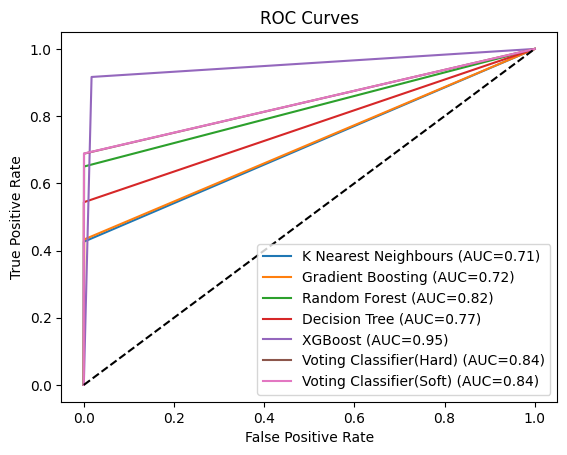

In [46]:
from sklearn.metrics import roc_curve, auc
models = [
    knn,
    gb,
    random,
    dtree,
    xgb,
    voting_hard,
    voting_soft    
]

y_preds = [model.predict(X_test) for model in models]

roc_curves = [roc_curve(y_test, y_pred) for y_pred in y_preds]
auc_scores = [auc(roc_curve[0], roc_curve[1]) for roc_curve in roc_curves]
model_name = ['K Nearest Neighbours','Gradient Boosting', 'Random Forest', 'Decision Tree', 'XGBoost', 'Voting Classifier(Hard)', 'Voting Classifier(Soft)']

fig, ax = plt.subplots()
for roc_curve, auc_score, model_name in zip (roc_curves,auc_scores,model_name):
    ax.plot(roc_curve[0], roc_curve[1], label=f"{model_name} (AUC={auc_score:.2f})")

plt.plot([0, 1], [0, 1.0], '--', color='black')


ax.set_title("ROC Curves")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()

plt.show()

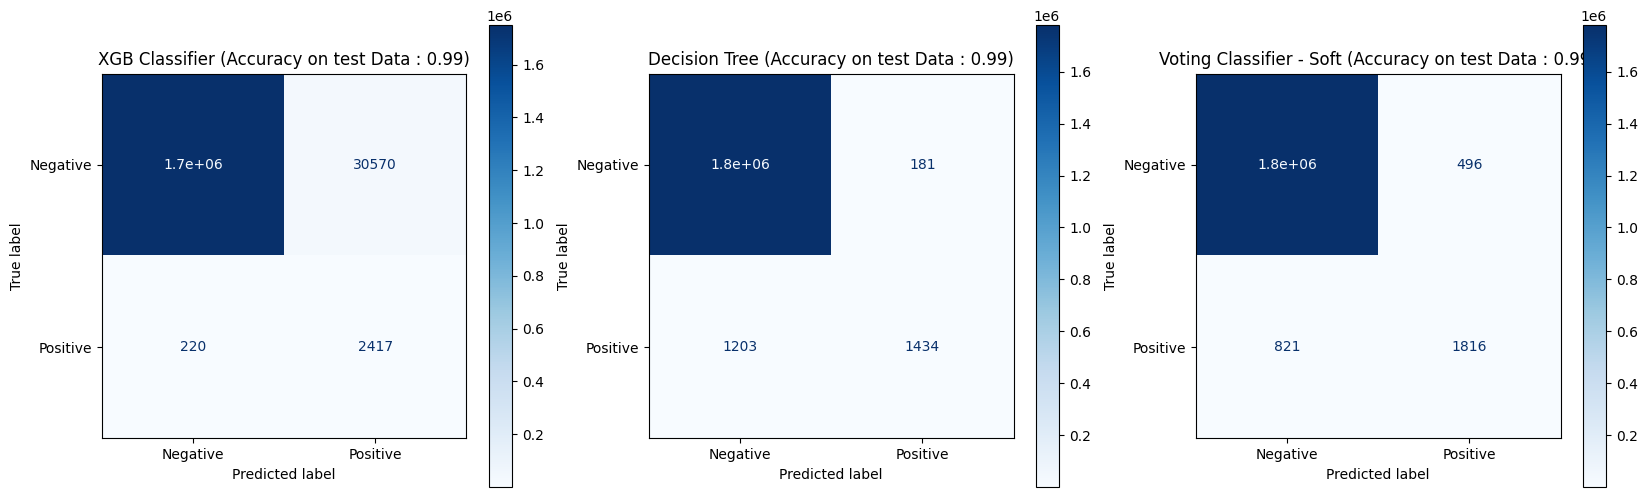

In [47]:
fig, ax = plt.subplots(1,3, figsize = (20,6))
ax[0].set_title("XGB Classifier (Accuracy on test Data : 0.99)")
ax[1].set_title("Decision Tree (Accuracy on test Data : 0.99)")
ax[2].set_title("Voting Classifier - Soft (Accuracy on test Data : 0.99)")


confusion_matrix = metrics.confusion_matrix(y_test, xgb.predict(X_test) )
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Negative', 'Positive'])
cm_display.plot(ax = ax[0], cmap='Blues')

confusion_matrix = metrics.confusion_matrix(y_test, dtree.predict(X_test))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Negative', 'Positive'])
cm_display.plot(ax = ax[1], cmap='Blues')

confusion_matrix = metrics.confusion_matrix(y_test, voting_soft.predict(X_test))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Negative', 'Positive'])
cm_display.plot(ax = ax[2], cmap='Blues')

plt.show()